# Intro

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
fm = FileManager()
preprocessing_config = fm.load_json('preprocessing-config.txt')

In [3]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [4]:
SEED = preprocessing_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [6]:
labels = labeled_with_target[['status_group']]

In [7]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [8]:
classes = list(let_labels.labelencoder.classes_)

In [9]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [10]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [12]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [13]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [14]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [15]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [16]:
cartesian_prod = 1
brute_force_complexity = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = preprocessing_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"$= {cartesian_prod}$ (brute-force iterations!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |amount_tsh|\times |source|\times |source_type|\times |source_class|\times |quantity|\times |quantity_group|\times |water_quality|\times |quality_group|\times |gps_height|\times |gps_coordinates|\times |waterpoint_type|\times |waterpoint_type_group|\times |installer|\times |population|\times |region_code|\times |district_code|\times |subvillage|\times |region|\times |lga|\times |ward|\times |scheme_management|\times |scheme_name|\times |pump_age|\times |payment_type|\times |payment|\times |num_private|\times |wpt_name|\times |basin|\times |public_meeting|\times |recorded_by|\times |permit|\times |management|\times |management_group|\times |funder|)$

$= 182250000000000$ (brute-force iterations!)

You read that correctly: if we do this using brute-force, that would require building (transforming) a virtually uncountable number of data sets.

That is obviously intractible.  

Consider the case when transforming both X_train and X_validation take, on average, 30 seconds apiece.

There are 525600 minutes in one year.

**Doing the brute-force way (the space of all possible combinations) would require about 347 million YEARS!!!**  LOL!

Instead, we will use a Greedy Algorithm to make this a linear problem.

## Baselining the Greedy Way - Another Exercise in Dynamic Programming

The idea goes like this:

1. Build a baseline model using the most features possible - since a lot of features contains `nan` values, this precludes the use of `DecisionTreeClassifier` and `RandomForestClassifier` for baselining; thus, we will baseline using `XGBClassifier` since it allows `nan`s.
2. From there, we will try out each option for each feature-group (specified in the config) - to be clear, we will include the baseline features plus those involved in the particular preprocessing option.
3. Build a model (with `XGBClassifier`) and compare its validation accuracy to the validation accuracy of the baseline model - if it goes down or stays the same, this obviously is not a good preprocessing option to keep; if it goes up from the baseline, then we will obviously keep this preprocessing option; we will keep the option that garners the best improvement on a per-feature-group basis.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [17]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = sorted(list(X_train_baseline.columns))
baseline_cols

['amount_tsh',
 'construction_year',
 'district_code',
 'gps_height',
 'latitude',
 'longitude',
 'num_private',
 'population',
 'region_code']

In [18]:
X_train_baseline = X_train_baseline[baseline_cols]
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [19]:
X_validation_baseline = X_validation[baseline_cols]

In [20]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [21]:
clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

### Iterate each preprocessing option (from config file), apply, compare results to Baseline - Keep the options that increase accuracy over Baseline

In [22]:
# the key, the heart of the algo...
def find_best_option(feature_group_name, preprocessing_group_name, best_options, y_acc):
    display(HTML(f"<h2 style='background-color: yellow;'>Finding best option for feature group <i>{feature_group_name}</i>, preprocessing group <i><font color='red'>{preprocessing_group_name}</font></i> after baseline...</h2>"))

    best = None
    preprocessing__group_options = preprocessing_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)
    
    cols_prior = []

    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h4 style='background-color: yellow;'>Transforming X with PRIOR best options...</h4>"))
        for prior_best_option in best_options:
            composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors
            )
            scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_train_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
            transformed_cols = set(transformed_cols)
            
            # filter out any columns that were dropped
            filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), baseline_cols)))
            display(HTML(f"<h5>baseline features in X after this transformation:</h5>"))
            display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
            
            # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
            cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
            prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
            # now we need to filter out the ones not in X
            filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), filtered_transformed_feat_names)))
            filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
            display(HTML(f"<h5>features (not in baseline) in X after transformation (including best priors):</h5>"))
            display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
            
            baseline_plus_transformed_cols = filtered_baseline_cols
            if len(filtered_transformed_feat_names) > 0:
                baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)
                
            cols_prior = baseline_plus_transformed_cols
            display(HTML(f"<h5>features included from prior best modes:</h5>"))
            display(HTML(f"<pre>{X_train_priors_transformed[cols_prior].info()}</pre>"))
            
        display(HTML(f"<h5>terminal features in prior best model:</h5>"))
        display(HTML(f"<pre>{X_train_priors_transformed[cols_prior].info()}</pre>"))
    
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = []

        display(HTML(f"<h4 style='background-color: yellow;'>Transforming X with option {idx+1}:</h4>"))
        composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
            preprocessing_option, 
            preprocessing_group_name,
            pipeline_temp
        )
        scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
        X_train_transformed = composite_transformer.fit_transform(X_train_priors_transformed.copy(), y_train_encoded.status_group)
        
        # get list of cols transformed by this option
        transformed_cols = []
        scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
        transformed_cols = set(transformed_cols)
        
        # filter out any columns that were dropped
        filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), baseline_cols)))
        display(HTML(f"<h5>baseline features in X after this transformation:</h5>"))
        display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
        
        # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
        cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
        prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
        # now we need to filter out the ones not in X
        filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), filtered_transformed_feat_names)))
        filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
        display(HTML(f"<h5>features (not in baseline) in X after transformation (including best priors):</h5>"))
        display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
        
        baseline_plus_transformed_cols = filtered_baseline_cols
        if len(filtered_transformed_feat_names) > 0:
            baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)

        cols_in_model.extend(baseline_plus_transformed_cols)
        display(HTML(f"<h5>features to be included in model:</h5>"))
        display(HTML(f"<pre>{X_train_transformed[cols_in_model].info()}</pre>"))

        if len(cols_in_model) > 0:
            display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            display(HTML(f"<h4>Transforming validation set with current option...</h4>"))
            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]

            display(HTML(f"<h4>Using model to predict y's on validation set...</h4>"))
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[3]:
                best = (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
                display(HTML(f"<h4 style='background-color: yellow;'>Option {idx+1} of this preprocessing-option group yields new BEST validation accuracy (of this group of options)!</h4>"))
        else:
            display(HTML(f"<h4><font color='red'>COULD NOT BUILD MODEL AS THERE ARE NO FEATURES TO BE INCLUDED!</font></h4>"))
        

        display(HTML("<p><br><br><br><br>"))

    if best[3] <= _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>NO OPTION INCREASES ACCURACY ABOVE BASELINE ({_accuracy_validation_baseline})!</font></h2>"))
    else:
        display(HTML(f"<h2><font color='green'>Best option increases accuracy to {best[3]} ABOVE BASELINE ({_accuracy_validation_baseline}) is:</font></h2>"))
        display(HTML(f"<pre>{(best[0], best[1], best[3])}</pre>"))

    return best, y_acc

In [23]:
# # test out individual preprocessing groups here, for example...
# best_options = []
# y_acc = []
# find_best_option('funder__group', 'funder', best_options, y_acc)
# find_best_option('pump_age_at_observation_date__group', 'pump_age', best_options, y_acc)

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed7fbf320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeda20d110>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9851710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbed98584d0>] to pipeline
strategy '(prefit) tar

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9851b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbed986e8d0>] to pipeline
strategy '(prefit) target-encode

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9873d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbed9877590>] to pipeline
strategy '(prefit) target-enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy "drop feature: extraction_type" appended step ['drop feature: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbed9858f50>] to pipeline
strategy "drop feature: extraction_type" transformation of feature "extraction_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


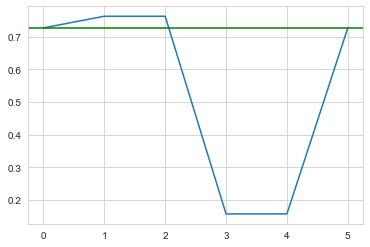

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee22890>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec50f18d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


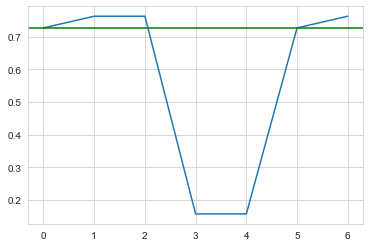

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4c1de60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4f93910>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee222d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4c1ebd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


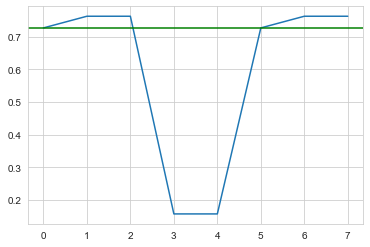

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec522a9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5258ed0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4f93e90>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5229910>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "leave feature as is (do nothing): amount_tsh" appended step ['leave feature as is (do nothing): amount_tsh', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec522ab00>)] to pipeline
strategy "leave feature as is (do nothing): amount_tsh" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d758d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   district_code                   53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   amount_tsh_target_encoded       53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4da7750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   district_code                   53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   amount_tsh_target_encoded       53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: amount_tsh_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d883b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 22 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after targ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   district_code                   53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   amount_tsh_target_encoded       53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 22 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: amount_tsh' appended step ['drop after target encoding: amount_ts

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   district_code                   53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   amount_tsh_target_encoded       53438 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: amount_tsh_target_encoded


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250c20>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy "replace "amount_tsh" outliers with mean" appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec523c810>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy "replace "amount_tsh" outliers with median" appended step ['replace "amount_tsh" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec5248190>] to pipeline
strategy "replace "amount_tsh" outliers with median" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy "drop feature: amount_tsh" appended step ['drop feature: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4da74d0>] to pipeline
strategy "drop feature: amount_tsh" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   district_code                   53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


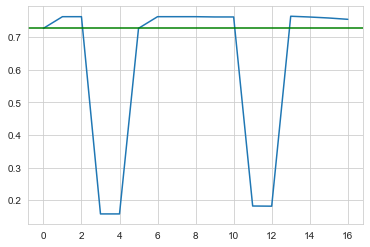

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec522a9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e51f10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e51450>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e51150>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5e4e560>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e50290>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7c890>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_me

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e503d0>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) t

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: source" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec53ee050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7cd10>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==Fals

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


strategy "drop feature: source" appended step ['drop feature: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d75f90>] to pipeline
strategy "drop feature: source" transformation of feature "source" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


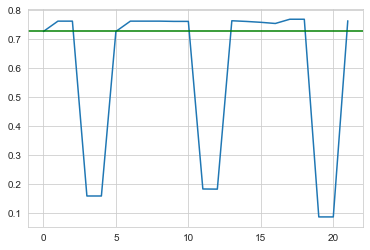

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5258090>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e51f10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d750d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec522a9e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5410f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec53e1f50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec53e1850>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


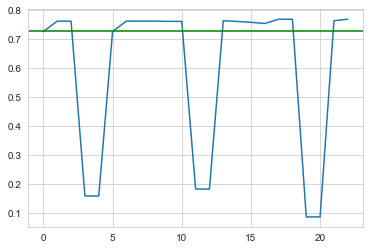

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587acb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4e11710>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4e115d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4e114d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5410320>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587a200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4dfd4d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec933a510>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4e11050>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


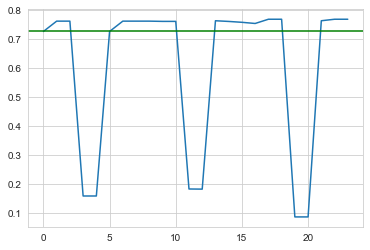

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9121050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501ae10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501ae50>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501a550>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4e1d3b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9121cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9136890>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9123310>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec910aad0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9121a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9112d50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5027560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9119190>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5027830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9101c10>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_m

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: quantity" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5776390>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_globa

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


strategy "drop feature: quantity" appended step ['drop feature: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec588bc90>] to pipeline
strategy "drop feature: quantity" transformation of feature "quantity" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


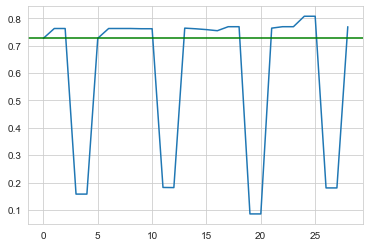

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9121050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501aa10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4dfded0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec588b610>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5793cb0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec57b9170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57df410>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5876ed0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9129a90>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec57b9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57df210>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57c0cd0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


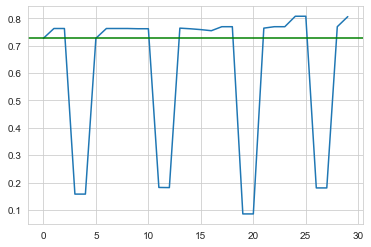

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ef50e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501a510>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56dc610>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56dcf50>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ed4d40>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ef5a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57df150>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57df410>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56dcd90>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ef5f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8ed8650>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57df8d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ef5e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8eea3d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec56f4050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56cde50>] to pipeline
strategy '(prefit) target-encoder 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec56f4170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56d65d0>] to pipeline
strategy '(prefit) target-encoder (LOO==True

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: water_quality" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec56f47a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56e4f50>] to pipeline
strategy '(prefit) target-encoder (LOO==T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy "drop feature: water_quality" appended step ['drop feature: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56d6090>] to pipeline
strategy "drop feature: water_quality" transformation of feature "water_quality" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


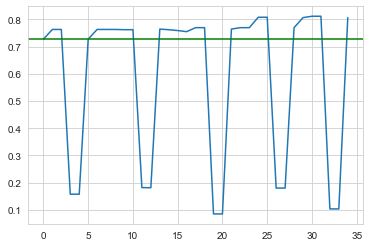

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ef5b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8ede310>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9136890>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5eda350>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5ec4b00>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8ef5dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56d60d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501af10>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501a690>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5ee9b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56d6e50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5edac90>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5ee95f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56dc750>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501ae50>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


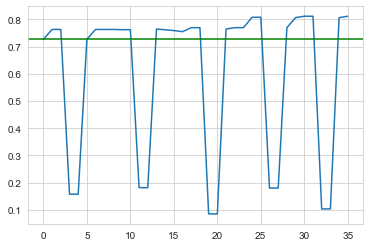

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f7d5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501a990>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5ed4990>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec913b150>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f498c0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f7d680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5eda3d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec501add0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec578cd90>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f49050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f719d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f76250>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f49ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f71d90>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f76210>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f494d0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f49cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
added new feature: gps_height_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height' appended step ['drop after target encoding: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4f93050>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  gps_height_target_encoded   

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: gps_height" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f49a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
added new feature: gps_height_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: gps_height' appended step ['drop after target encoding: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec525c210>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  gps_height_target_encoded   

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: gps_height" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f497a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'gps_height' has 132 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: gps_height_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: gps_height' appended step ['drop after tar

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  gps_height_target_encoded   

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: gps_height" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f49e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'gps_height' has 132 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: gps_height_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: gps_height' appended step ['drop after target encoding: gps_heig

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  gps_height_target_encoded   

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: gps_height" appended step ['drop feature: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4f93090>] to pipeline
strategy "drop feature: gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(7), int64(5)
memo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


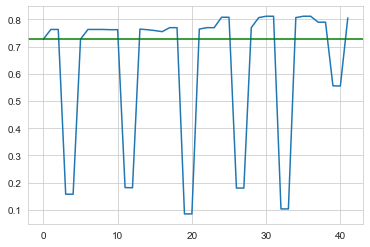

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca320ed0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8ed8910>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f5c590>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9f49950>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca314050>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f766d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca320c10>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca314790>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca3200d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec52503b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca32f590>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca314150>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5e2d320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbeca9e7050>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy "drop feature: latitude" appended step ['drop feature: latitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca327a50>] to pipeline
strategy "drop feature: latitude" transformation of feature "latitude" is COMPLETE!
strategy "drop feature: longitude" appended step ['drop feature: longitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5ee32d0>] to pipeline
strategy "drop feature: longitude" transformation of feature "longitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   num_private                     53460 non-null  int64  
 5   population                      53460 non-null  int64  
 6   region_code                     53460 non-null  int64  
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   source_target_encoded           53460 non-null  float64
 10  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


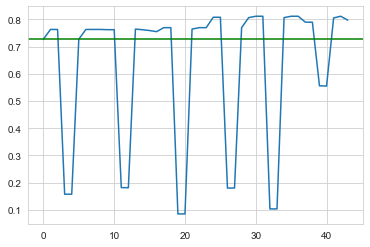

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c4c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f76d90>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca2f7b10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca9f3910>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250170>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c4a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165250>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca9dce10>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca9f3cd0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c4e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56dcc10>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c4b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165bd0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca147810>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99abcb0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec99ca710>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec51694d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec99b0590>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec51697a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec515ddd0>] to pipeline
strategy '(prefit) tar

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec51699e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec99bb650>] to pipeline
strategy '(prefit) target-encode

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5169170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165a50>] to pipeline
strategy '(prefit) target-enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: waterpoint_type" appended step ['drop feature: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca9dc450>] to pipeline
strategy "drop feature: waterpoint_type" transformation of feature "waterpoint_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


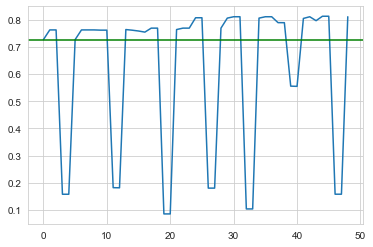

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec518dc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca314790>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5ed4650>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5ec8c90>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250170>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c4c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca314550>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec56dcc10>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec515d950>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c40e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca32fd10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165bd0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec518d950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec99bb750>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec99bb650>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec51699e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec99d9450>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64df9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f69ad0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec99c2110>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

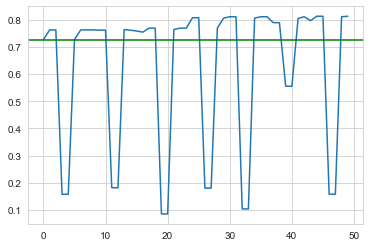

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91d18c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec515d250>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca314c50>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec515d090>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99c4a70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca327490>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca32f590>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165350>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec91d3c90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec515d350>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec91d37d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5165690>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64df5f0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec92dc390>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dce50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec64d2390>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9e60>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec92d3

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9560>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec5165

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c97a0>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec863e

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9560>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63af

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9b90>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9f69

strategy "tfidf normalize string-categorical: installer" appended step ['tfidf normalize string-categorical: installer', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9ef0>)] to pipeline


strategy "tfidf normalize string-categorical: installer" transformation of feature "installer" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'installer' in X match those that were previously fit
added new feature: installer_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer' appended step ['drop after target encoding: installer', <scjpnlib.utils.skl_transformers.DropColumnsTran

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 28 categories of 'installer' occur in X (out of 521 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'installer' has 31 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: installer_target_encoded


strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca3149d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

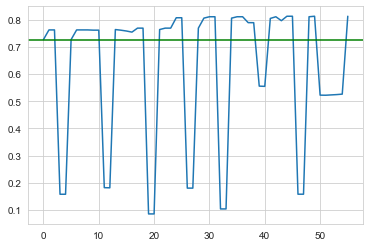

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c7490>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63d4350>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63d4510>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64df830>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9873c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c7450>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63be610>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63be050>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c7310>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63cb890>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c1690>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c7810>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92c9710>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63c1e90>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d883b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c7750>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c7710>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c1850>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): population" appended step ['leave feature as is (do nothing): population', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9851b90>)] to pipeline
strategy "leave feature as is (do nothing): population" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
added new feature: population_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population' appended step ['drop after target encoding: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec86244d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: population" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
added new feature: population_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: population' appended step ['drop after target encoding: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec86370d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: population" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'population' has 320 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: population_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: population' appended step ['drop after tar

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: population" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9851b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'population' has 320 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: population_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: population' appended step ['drop after target encoding: populati

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   region_code                     53460 non-null  int64  
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed9851cb0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace "population" outliers with mean" appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63d26d0>] to pipeline
strategy "replace "population" outliers with mean" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace "population" outliers with mean" appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63bb610>] to pipeline
strategy "replace "population" outliers with mean" transformation of feature "population" is COMPLETE!
strategy "replace "population" outliers with mean" appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63bb110>] to pipeline
strategy "replace "population" outliers with mean" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace "population" outliers with median" appended step ['replace "population" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbeca32fa90>] to pipeline
strategy "replace "population" outliers with median" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "leave feature as is (do nothing): population" appended step ['leave feature as is (do nothing): population', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88680>)] to pipeline
strategy "leave feature as is (do nothing): population" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

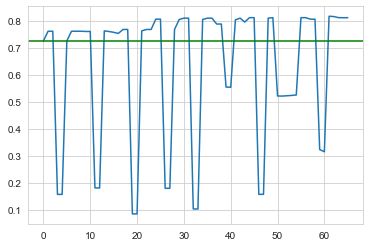

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92f4320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b5c10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b3fd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622d10>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92f4cb0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca3034d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5dee410>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5deeb90>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63d3610>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca3039e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5dee2d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b5e90>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca3035f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6378050>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6378dd0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d880e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63b72d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b7550>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e96890>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63970d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303830>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63911d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b8bd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False,

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'region_code' has 1 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: region_code" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'region_code' has 1 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: region_code' appended step ['drop after target encoding: regi

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: region_code" appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec639a790>] to pipeline
strategy "drop feature: region_code" transformation of feature "region_code" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

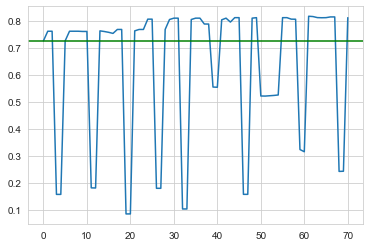

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92f5ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b6550>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b6790>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec639f410>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd710>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec638fd50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec638f6d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b3d50>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca303290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec638f050>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b3fd0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca3038c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6378210>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec638f950>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92f4cb0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63b53d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fdef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63790d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63798d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6379b10>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd5f0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63a7d50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad550>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fde60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af0d0>] to pipeline
strategy '(prefit) target-encoder 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fdb00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6379690>] to pipeline
strategy '(prefit) target-encoder (LOO==True

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: district_code" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637d750>] to pipeline
strategy '(prefit) target-encoder (LOO==T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: district_code" appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad0d0>] to pipeline
strategy "drop feature: district_code" transformation of feature "district_code" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

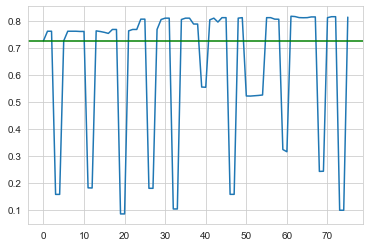

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391a50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637fd90>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f9d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec92f50e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c47a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af150>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f690>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f710>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af3d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63913d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af310>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af750>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd9e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec8622550>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622c10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391910>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63914d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fd290>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ada10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c49e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637d650>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622a50>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

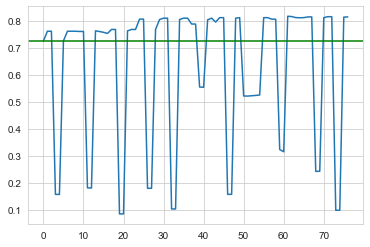

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391650>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f210>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f810>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c47a0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fddd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ade10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391310>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391150>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad810>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637fb50>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad790>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b9610>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250830>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63af3d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4c1d440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af610>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391c10>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63a72d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4680>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec86221d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fdb00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec99bb610>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391690>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63c1a10>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

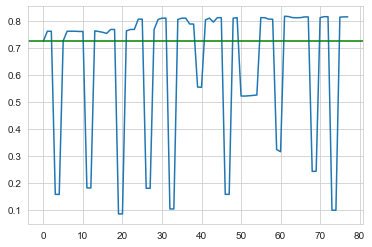

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c49e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63affd0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63a72d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63794d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4c1d440>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c47a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af710>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad510>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622d90>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fdb00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ada10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622ad0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9eef80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391e50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b9bd0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250830>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec637f690>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b68d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b9f50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b9610>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223ef0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fddd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6368510>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1fda90>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3b610>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f650>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1fdcd0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

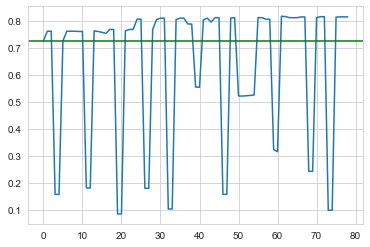

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6379ed0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622c90>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4f93ed0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4c1d440>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c49e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622590>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622ad0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec55fddd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad9d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeeb0baf50>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad450>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63793d0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223ef0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6368510>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad2d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af110>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622d90>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9eef80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec502a200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec502af80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5242710>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbed986e310>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3bfd0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec52427d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3b7d0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

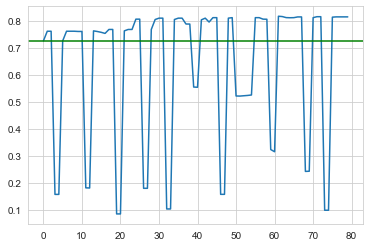

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391c10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec64e6390>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6368a50>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9eef80>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad790>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6368510>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6391d10>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f610>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637f910>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec637fd50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec524bdd0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c47a0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbed986e3d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec524b910>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec524bf50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63af790>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2f80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fb0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca324d50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fb170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca324c90>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b9150>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec91f3ed0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca324e90>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec91f31d0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "impute lower-case transform: scheme_management" appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9cb0>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation of feature "scheme_management" is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_management" appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec5235c10>] to pipeline
strategy "replace values for feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transfor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 51357
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   amount_tsh                        15999 non-null  float64
 1   construction_year                 53460 non-null  int64  
 2   gps_height                        53460 non-null  int64  
 3   latitude                          53460 non-null  float64
 4   longitude                         53460 non-null  float64
 5   num_private                       53460 non-null  int64  
 6   population                        34150 non-null  float64
 7   district_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded    53460 non-null  float64
 9   quantity_target_encoded           53460 non-null  float64
 10  region_code_target_encoded        53460 non-null  float64
 11  source_target_encoded             53460 non-null  float64
 12  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_management" appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223ef0>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation of feature "scheme_management" is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_management" appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6231190>] to pipeline
strategy "replace values for feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transfor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 51357
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   amount_tsh                        15999 non-null  float64
 1   construction_year                 53460 non-null  int64  
 2   gps_height                        53460 non-null  int64  
 3   latitude                          53460 non-null  float64
 4   longitude                         53460 non-null  float64
 5   num_private                       53460 non-null  int64  
 6   population                        34150 non-null  float64
 7   district_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded    53460 non-null  float64
 9   quantity_target_encoded           53460 non-null  float64
 10  region_code_target_encoded        53460 non-null  float64
 11  source_target_encoded             53460 non-null  float64
 12  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_management" appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9950>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation of feature "scheme_management" is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_management" appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9d9fb90>] to pipeline
strategy "replace values for feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transfor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 51357
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   amount_tsh                        15999 non-null  float64
 1   construction_year                 53460 non-null  int64  
 2   gps_height                        53460 non-null  int64  
 3   latitude                          53460 non-null  float64
 4   longitude                         53460 non-null  float64
 5   num_private                       53460 non-null  int64  
 6   population                        34150 non-null  float64
 7   district_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded    53460 non-null  float64
 9   quantity_target_encoded           53460 non-null  float64
 10  region_code_target_encoded        53460 non-null  float64
 11  source_target_encoded             53460 non-null  float64
 12  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_management" appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9b00>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation of feature "scheme_management" is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_management" appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6407b90>] to pipeline
strategy "replace values for feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transfor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 51357
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   amount_tsh                        15999 non-null  float64
 1   construction_year                 53460 non-null  int64  
 2   gps_height                        53460 non-null  int64  
 3   latitude                          53460 non-null  float64
 4   longitude                         53460 non-null  float64
 5   num_private                       53460 non-null  int64  
 6   population                        34150 non-null  float64
 7   district_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded    53460 non-null  float64
 9   quantity_target_encoded           53460 non-null  float64
 10  region_code_target_encoded        53460 non-null  float64
 11  source_target_encoded             53460 non-null  float64
 12  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9fb10>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

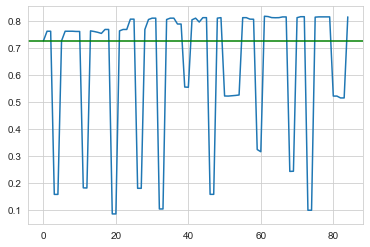

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231890>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231710>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4da7710>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91d3b00>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca307b90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4da71d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca3225d0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fb170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca3074d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63b5a90>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fb0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca3073d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca31b550>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e2170>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec5401090>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9f510>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5248dd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5242d90>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c47a0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6219150>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fb7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad790>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec62195d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6219c50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec64fa8d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622710>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6219cd0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223ef0>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec53fc610>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca223050>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec636c110>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec64d9d40>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6228890>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec50c4560>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec81087d0>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fba70>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec84bae50>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

strategy "tfidf normalize string-categorical: scheme_name" appended step ['tfidf normalize string-categorical: scheme_name', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca2fb290>)] to pipeline


strategy "tfidf normalize string-categorical: scheme_name" transformation of feature "scheme_name" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9e11290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'scheme_name' in X match those that were previously fit
added new feature: scheme_name_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name' appended step ['drop after target encoding: scheme_name', <scjpnlib.utils.skl_transformers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 22 categories of 'scheme_name' occur in X (out of 1085 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'scheme_name' has 35 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: scheme_name_target_encoded


strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec622d150>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

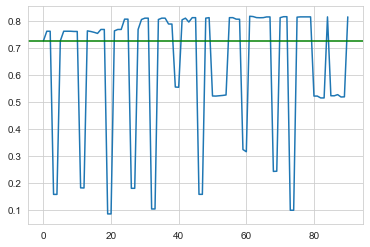

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f976d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f97150>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8f7d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9e11950>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a890>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb59d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8f250>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a990>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fa23d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a690>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f92a50>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5e3cf80>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9fb0750>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb04d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f92250>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a810>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044b90>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fa7910>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f92210>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f9cd10>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec91f33d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fa79d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8ac50>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f9c7d0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb55d0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88a70>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "replace 0 with date_recorded value: construction_year" appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9e11680>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation of feature "construction_year" is COMPLETE!
strategy "convert (from string date format '%Y') to datetime type: construction_ye

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   num_private                     53460 non-null  int64  
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab910>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044e60>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219680>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "replace 0 with date_recorded value: construction_year" appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed98510e0>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation of feature "construction_year" is COMPLETE!
strategy "convert (from string date format '%Y') to datetime type: construction_ye

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0f50>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "drop feature: construction_year" appended step ['drop feature: construction_year', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8af50>] to pipeline
strategy "drop feature: construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   num_private                     53460 non-null  int64  
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

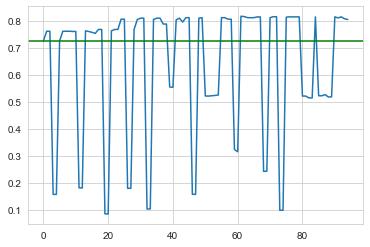

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed7fcb830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9daf910>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9dafc90>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9daf790>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044f80>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf510>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf490>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fc44d0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f97910>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fa2390>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf710>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf290>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed7fcb8c0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec91f33d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fa7a10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0290>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9dafe90>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219d40>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb59d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8acd0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf910>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a510>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca164210>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a9d0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1728d0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fc4a90>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e4d0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca183090>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca198b50>] to pipeline
strategy '(prefit) target-encoder (LOO==

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501ee60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9a1d0>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: payment_type" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9dc5350>] to pipeline
strategy '(prefit) target-encoder (LOO==True, p

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb01d0>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

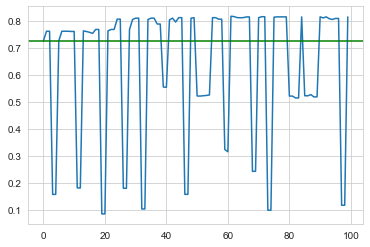

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed7fcb8c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca18d490>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8fe50>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca183250>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec4d88290>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63336d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9114710>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec64e6550>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5044f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9faba50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8f850>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec501e050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0d50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca17e950>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca219d40>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9fbf490>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec933c170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabe10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca164110>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1645d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed7fcb440>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec933cef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a790>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec933c200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9a3d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec633fa90>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0390>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a750>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb04d0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fc4e50>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf290>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec633f790>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec933c050>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf850>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf150>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

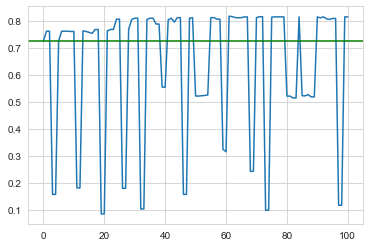

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5787dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9faba10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca18d490>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb55d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5787b00>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e99e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabf10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeef7643d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fc44d0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6333a90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec633f790>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0290>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab890>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbed7fcb440>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9f0ea90>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ed90>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ef50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1646d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec933c050>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee070d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee35350>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec633f890>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8ae50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fc47d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec911df90>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f1f650>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07bd0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07290>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9b90>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee35f50>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee35210>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9daf7d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

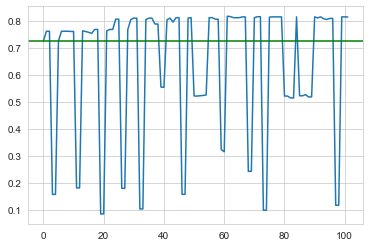

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabd10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63687d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0310>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec810ca70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ef50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeef7643d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabbd0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabb10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a690>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec91145d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee386d0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec810c7a0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9fbfc10>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee35d10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf910>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1728d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b05f0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b07a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca2f7e90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b09e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07ad0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8caeb10>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1980d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80eee90>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07890>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80eee10>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07290>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ee650>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0b00>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07850>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca2f7a10>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ee750>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec911d790>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

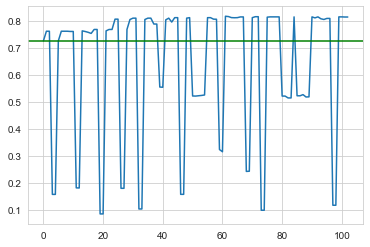

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0e910>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca164110>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63336d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9a70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ef10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8aad0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab890>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf150>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabb50>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca2f7210>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab650>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9dc2320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbeca2f73d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ee750>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8f7d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabc10>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca9e9d40>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8629550>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca2f7dd0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee29510>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9abd0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07390>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee35210>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07090>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8629b10>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbf910>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6c20>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fbfc10>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee29e50>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee070d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee07110>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "impute lower-case transform: basin" appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6830>)] to pipeline
strategy "impute lower-case transform: basin" transformation of feature "basin" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: basin" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strat

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: basin" appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9dc2440>)] to pipeline
strategy "impute lower-case transform: basin" transformation of feature "basin" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: basin" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
str

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: basin" appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6cb0>)] to pipeline
strategy "impute lower-case transform: basin" transformation of feature "basin" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: basin" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strategy '(

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: basin" appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0b00>)] to pipeline
strategy "impute lower-case transform: basin" transformation of feature "basin" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: basin" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e67a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strategy 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec631b4d0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

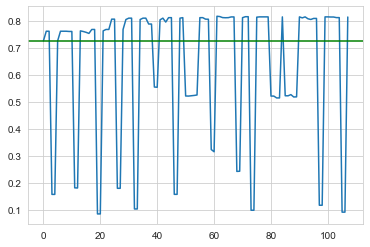

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8619bd0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f01790>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cae3d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec84bc440>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ed90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ea10>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f01ad0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e69e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabb50>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab8d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab890>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0710>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec8629e50>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca1a15f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8629850>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabdd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8fe50>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6680>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca1a14d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec93469d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca1a1830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5f4c350>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec578b810>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec578b850>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec93467d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9301890>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fc8d0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9301bd0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8629310>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbeca1a1290>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5f4cb10>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec53fb850>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabbd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8629510>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6333150>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "replace values for feature: public_meeting" replacement_rules:
{
    "public_meeting": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy "replace values for feature: public_meeting" appended step ['replace values for feature: public_meeting', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbedee37990>] to pipeline
strategy "replace values for feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!
strategy "leave feature as is (do nothing): public_meeting" appended step ['leave feature as is (do nothing): public_meeting', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec99b0680>)] to pipeline
strategy "leave feature as is (do nothing): public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8633e50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

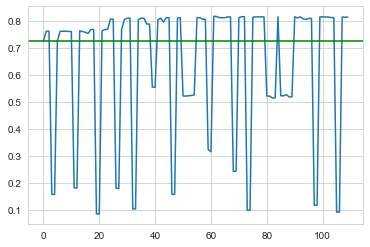

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9114d50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6326410>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63260d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec84bc710>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec63bbcb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80eef50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8619bd0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231450>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec63bbdd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6326650>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cae3d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec63bb9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231b50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ee150>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec84bc440>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec578b810>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec63bb0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0e8d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fc450>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92ff150>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6a70>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec62460e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec62463b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8a50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fdbd0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fdad0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fcc50>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fd3d0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346850>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fd1d0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346f10>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec6246050>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8d10>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8fe50>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8290>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec578ba10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fab8d0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8629d50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346810>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

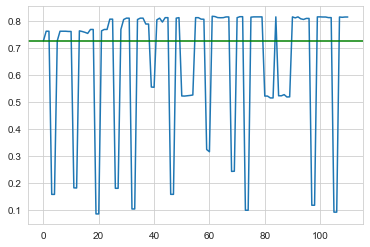

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec622ecb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ee650>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeef7643d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80eef50>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec622e9e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0c50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0750>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0d50>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346cd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63687d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8d10>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec93469d0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec6246050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbeca30d550>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30d9d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30ddd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8b90>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec91e6440>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec50c3310>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec50c3610>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231910>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca307650>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30db90>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346350>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca324250>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb04d0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8b10>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56f80>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fabbd0>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedee0b850>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92e82d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9fa50>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca3245d0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca1645d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92e8250>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "replace values for feature: permit" replacement_rules:
{
    "permit": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy "replace values for feature: permit" appended step ['replace values for feature: permit', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6407fd0>] to pipeline
strategy "replace values for feature: permit" transformation of feature "permit" is COMPLETE!
strategy "leave feature as is (do nothing): permit" appended step ['leave feature as is (do nothing): permit', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56ef0>)] to pipeline
strategy "leave feature as is (do nothing): permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca324910>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

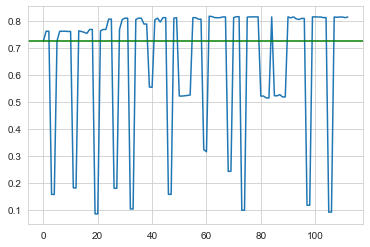

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9df4950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec50c3d50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fdf10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0ea90>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec9df4680>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30da10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec50c3c90>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231550>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30dbd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231c10>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c65f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0e90>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30db90>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec622ecb0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9fab8d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca322290>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd090>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec50c3910>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56710>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c67a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec53e1f10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c64d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec53e1050>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5254590>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5254c90>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7c590>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7cad0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8990>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec52549d0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd3d0>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6dd0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5254e10>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd750>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7cb10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7cdd0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec4d7c390>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9d9f3d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec52541d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec53e1c90>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f81d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd510>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c68c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5248110>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post_encode_null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: management" appended step ['(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==True, post_encode_null_to_global_mean==False) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5248950>] to pipeline
strategy '(prefit) target-encoder (LOO==True, post_encode_n

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "drop feature: management" appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3b950>] to pipeline
strategy "drop feature: management" transformation of feature "management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

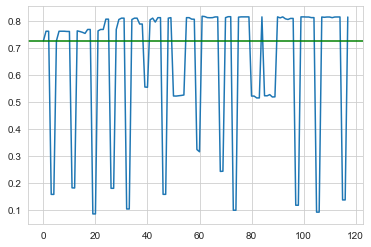

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec6246050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6407f50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622cd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622fd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8f00440>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c68c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedd74a950>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f9c7d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedd74a290>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5770b90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8a690>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5770890>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8622590>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec622ecb0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6231e50>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231550>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346150>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57709d0>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8f00830>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c64d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f540d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5f56cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca322290>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca322c10>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f8aad0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f0e8d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca322890>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30dbd0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd6d0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30dcd0>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c67a0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92ddc50>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd350>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30df90>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8690>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca322690>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30da50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0750>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd3d0>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c81440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3bc50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8990>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

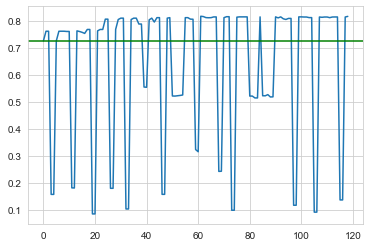

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c67a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cac7d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cac990>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ffcd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      53460 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c81200>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c770e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca164110>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92fdad0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63ad310>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c77560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cacb50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  quantity_target_encoded         53460 non-null  float64
dtypes: float64(6), int64(6)
memo

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cac5d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
dtypes: float64(6), int64(6)
memo

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c77dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cac090>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5248290>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c77d40>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec6231450>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d75f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231b50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92ff150>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cace10>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      53460 non-null  int64  
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec83c6cb0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   region_code                     53460 non-null  int64  
 9   extraction_type_target_encoded  53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d70e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346150>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   district_code                   53460 non-null  int64  
 3   gps_height                      53460 non-null  int64  
 4   latitude                        53460 non-null  float64
 5   longitude                       53460 non-null  float64
 6   num_private                     53460 non-null  int64  
 7   population                      34150 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d74d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5770ad0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec80ff690>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0c50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9300dd0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec62315d0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9346350>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3bb10>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9fb0ad0>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d7200>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec8cac950>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92dd750>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   num_private                     53460 non-null  int64  
 6   population                      34150 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9f9c7d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3ba90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbeca30df90>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5e3b390>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbedd74ac10>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec92f8690>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d7560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec5d52c90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   quantity_target_encoded         53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  source_target_encoded           53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  waterpoint_type_target_encod

strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6231e50>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c77290>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec8ed4350>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec8c81320>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec9e41c90>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d7a70>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec63d5850>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d7cb0>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec84ba9d0>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d7dd0>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec4d73150>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

strategy "tfidf normalize string-categorical: funder" appended step ['tfidf normalize string-categorical: funder', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d79e0>)] to pipeline


strategy "tfidf normalize string-categorical: funder" transformation of feature "funder" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec58d73b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'funder' in X match those that were previously fit
added new feature: funder_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder' appended step ['drop after target encoding: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 25 categories of 'funder' occur in X (out of 527 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'funder' has 27 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: funder_target_encoded


strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6374290>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amount_tsh                      15999 non-null  float64
 1   construction_year               53460 non-null  int64  
 2   gps_height                      53460 non-null  int64  
 3   latitude                        53460 non-null  float64
 4   longitude                       53460 non-null  float64
 5   population                      34150 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

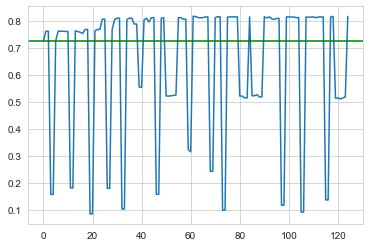

In [24]:
best_options = []
y_acc = [_accuracy_validation_baseline] # so we the appropriate starting point
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    plt.figure()
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        best_option, y_acc = find_best_option(feat_group_name, preprocessing_group_name, best_options, y_acc)
        best_options.append(best_option)

        plt.plot(list(range(len(y_acc))), y_acc)
        plt.axhline(y=_accuracy_validation_baseline, color="red" if best_option[3] < _accuracy_validation_baseline else "green")
        plt.show()

        display(HTML("<p><br><br><br><br>"))

## Test Best Preprocessing Options Transformations on `X_train`

In [25]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [26]:
X_train_preprocessed = X_train.copy()

for best_preprocessing_option in best_options:
    composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        best_preprocessing_option[1], 
        best_preprocessing_option[0],
        pipeline_data_preprocessor
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
    X_train_preprocessed = composite_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587a320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da46d0>] to pipeline
strategy '(prefit) target

strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57a0050>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57a0790>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587ad40>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587a7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da49d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57a0290>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec64078d0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da4b90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da4c90>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da4390>] to pipeline
strategy '(prefit) target-encoder (LO

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec57a0c90>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587a560>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fbec620b5d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec52509e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620bbd0>] to pipeline
strategy '(prefit) target

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da4a50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da4c10>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec587a170>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620b450>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358ad0>] to pipeline
strategy '(prefit) target-encoder (LO

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620b490>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620bb50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620bc10>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6383750>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620bd50>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620bed0>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620b890>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec52507a0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358c90>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358490>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358c50>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358710>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358610>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358250>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63589d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec6358350>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fbec5250cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec63831d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec620b990>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fbec9da4410>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


In [27]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

## Save Transformed Training Data to CSV for Final Model Building

### Save Configuration First

In [28]:
best_preprocessing_config = {}

for best_preprocessing_option in best_options:
    best_preprocessing_config.update({best_preprocessing_option[0]: best_preprocessing_option[1]})

best_preprocessing_config

{'extraction_type': [['extraction_type',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'extraction_type_group': [['extraction_type_group',
   'C__drop_it__StrategyTransformer']],
 'extraction_type_class': [['extraction_type_class',
   'C__drop_it__StrategyTransformer']],
 'amount_tsh': [['amount_tsh', 'C__replace_0_with_nan__StrategyTransformer']],
 'source': [['source',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'source_type': [['source_type', 'C__drop_it__StrategyTransformer']],
 'source_class': [['source_class', 'C__drop_it__StrategyTransformer']],
 'quantity': [['quantity',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quantity_group': [['quantity_group', 'C__drop_it__StrategyTransformer']],
 'water_quality': [['water_quality',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quality_group': [['quality_group', 

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_validation`

In [40]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [41]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

In [42]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_unlabeled`

In [50]:
scjpnutils.analyze_values(X_unlabeled, 'X_unlabeled BEFORE preprocessing');

In [51]:
X_unlabeled_preprocessed = pipeline_data_preprocessor.transform(X_unlabeled)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

In [52]:
scjpnutils.analyze_values(X_unlabeled_preprocessed, 'X_unlabeled AFTER preprocessing');

## Save Best Preprocessing Options (as Preprocessing Spec) to File

In [55]:
# used at the end of this process
if len(preprocessing_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = preprocessing_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(preprocessing_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = preprocessing_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

In [56]:
fname__best_options_cfg, fname__last_preprocessing_spec = scjpnutils.get_preprocessing_options_fname(preprocessing_config, best_preprocessing_config)
fname__best_options_cfg = WRANGLED_DATA_DIR + fname__best_options_cfg
fname__last_preprocessing_spec = WRANGLED_DATA_DIR + fname__last_preprocessing_spec
print(f"best preprocessing options config will be saved to: {fname__best_options_cfg}")
print(f"best preprocessing options config will be saved as last preprocessing spec to: {fname__last_preprocessing_spec}")

best preprocessing options config will be saved to: preprocessing-results/preprocessing-options-97d21e43336353d6c298c8760b753c0b.json
best preprocessing options config will be saved as last preprocessing spec to: preprocessing-results/preprocessing-spec-last.json


In [57]:
fm.save_json(best_preprocessing_config, f"{fname__best_options_cfg}")
print(f"updated {fname__best_options_cfg}")

# also save canonical for model building
fm.save_json(best_preprocessing_config, f"{fname__last_preprocessing_spec}")
print(f"updated {fname__last_preprocessing_spec}")

updated preprocessing-results/preprocessing-options-97d21e43336353d6c298c8760b753c0b.json
updated preprocessing-results/preprocessing-spec-last.json


# Conclusion

We're now ready to move on to the final model building stage.